# This notebook is used to generate Functional Connectivity Matrix for all of the nifty BOLD images in the directory provided

In [1]:
import numpy as np
import glob
import pathlib
from nilearn.datasets import fetch_atlas_msdl, fetch_atlas_aal, fetch_development_fmri, fetch_atlas_difumo
from nilearn.image import load_img
from nilearn.maskers import NiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
from nilearn.interfaces.fmriprep import load_confounds

### Defining a functions for generating FC matrix and testing the validity of the FC matrix from a path to 1 nifty file

In [2]:
def MaskerBuilder(atlas):
    atlas_filename = atlas["maps"]
    labels = atlas["labels"]
    masker = NiftiMapsMasker(
        maps_img=atlas_filename,
        standardize="zscore_sample",
        standardize_confounds="zscore_sample",
        memory="nilearn_cache",
    )
    return masker

In [3]:
def MaskReportGenerator(masker):
    report = masker.generate_report(displayed_maps=[2, 6, 7, 16, 21])
    return report

In [4]:
def TimeSeriesExtractor(img_path, masker):
    nifti_path = img_path
    fmri_img = load_img(nifti_path)
    confounds_simple, sample_mask = load_confounds(
        nifti_path,
        strategy=["high_pass", "motion", "wm_csf"],
        motion="basic",
        wm_csf="basic",
    )
    time_series = masker.fit_transform(fmri_img, confounds=confounds_simple, sample_mask=sample_mask)
    return time_series

In [5]:
def FCMGenerator(img_path, masker):
    time_series = TimeSeriesExtractor(img_path=img_path, masker=masker)
    correlation_measure = ConnectivityMeasure(
        kind="correlation",
        standardize="zscore_sample",
    )
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    np.fill_diagonal(correlation_matrix, 0)
    return correlation_matrix


#### Testing the functions above

In [6]:
path = '..\\data\\sub-StrokeR01001S\\func\\sub-StrokeR01001S_task-rest_dir-PA_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz'
atlas = fetch_atlas_difumo(dimension=64, resolution_mm=2, legacy_format=True) #choose atlas as diFuMo because nifty images are BOLDS
masker = MaskerBuilder(atlas)
FCM = FCMGenerator(path, masker)

[get_dataset_dir] Dataset found in C:\Users\Administrator\nilearn_data\difumo_atlases

d:\Python313\Lib\site-packages\nilearn\maskers\base_masker.py:297: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  return self.transform_single_imgs(


## Functions used for visualization

(64, 64)


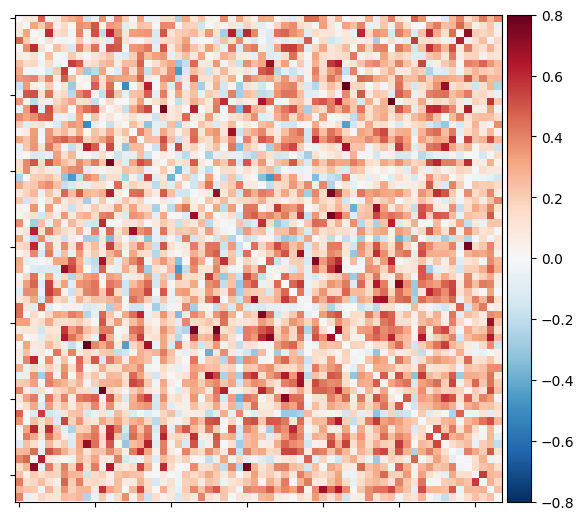

In [7]:
def PLotFCM(FCM, labels = None, colorbar_True_or_False = True, vmax = 0.8, vmin = -0.8):
    plotting.plot_matrix(
        FCM, labels=labels, colorbar=colorbar_True_or_False, vmax=vmax, vmin=vmin, 
    )
    print(FCM.shape)
PLotFCM(FCM, None, True, 0.8, -0.8)

In [8]:
report = MaskReportGenerator(masker=masker)
report

In [9]:
def PlotCoordinates(atlas, FCM, dim):
    coordinates = plotting.find_probabilistic_atlas_cut_coords(
        maps_img=atlas.maps
    )

    # plot connectome with 85% edge strength in the connectivity
    plotting.plot_connectome(
        FCM,
        coordinates,
        edge_threshold="85%",
        title=f"DiFuMo with {dim} dimensions (probabilistic)",
    )
    plotting.show()

In [10]:
def PlotWebView(atlas, FCM):
    coordinates = plotting.find_probabilistic_atlas_cut_coords(
        maps_img=atlas.maps
    )
    view = plotting.view_connectome(
        FCM, coordinates, edge_threshold="80%"
    )
    view.save_as_html('Connectome_Webview.html')
    print("Check the folder for file name \'Connectome_Webview.html\' and click on it.")

#### Finish testing

## Function for loading all nifty files within a directory path

In [11]:
def GetNiftyPaths(dir_path):
    return list(pathlib.Path(dir_path).glob('*.nii.gz'))

## Function for saving/loading Functional Connectivity Matrix to/from a path

In [12]:
def SaveFCM(output_dir, output_file_name, FCM):
    full_path = output_dir / output_file_name
    print("File will be saved at:", full_path)
    np.savetxt(full_path, FCM)
    b = np.loadtxt(full_path)
    return FCM == b

def LoadFCM(mattrix_path):
    FCM = np.loadtxt(mattrix_path)
    return FCM

## The whole process

In [13]:
import re
def location_of_pattern_in_string(pattern, string): #Helper function for getting the sub...
    match = re.search(pattern, string)
    if match:
        return match.start()
    else:
        return None

In [14]:
files_path = '..\\data\\sub-StrokeR01001S\\func' #Make a list for getting all NIFTI files
nifty_paths = GetNiftyPaths(files_path)
print(nifty_paths)
preprocessed_data_dir = pathlib.Path('..\\preprocessed\\fcm')
atlas = fetch_atlas_difumo(dimension=64, resolution_mm=2, legacy_format=True) #choose atlas as diFuMo because nifty images are BOLDS
masker = MaskerBuilder(atlas)
for path in nifty_paths:
    path_as_str = path.__str__()
    FCMatrix = FCMGenerator(path_as_str, masker)
    start = location_of_pattern_in_string("sub-Stroke", path_as_str)
    # end = location_of_pattern_in_string("\\", path_as_str)
    filename = path_as_str[start:(start + 16)] + "-FC_Matrix" + ".txt"
    print("File will be saved as name:", filename)
    SaveFCM(output_dir=preprocessed_data_dir, output_file_name=filename, FCM=FCMatrix)

LoadedFCM = LoadFCM('..\\preprocessed\\fcm\\sub-StrokeR01001-FC_Matrix.txt')
    

[WindowsPath('../data/sub-StrokeR01001S/func/sub-StrokeR01001S_task-rest_dir-PA_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz')]
[get_dataset_dir] Dataset found in C:\Users\Administrator\nilearn_data\difumo_atlases


d:\Python313\Lib\site-packages\nilearn\maskers\base_masker.py:297: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  return self.transform_single_imgs(


File will be saved as name: sub-StrokeR01001-FC_Matrix.txt
File will be saved at: ..\preprocessed\fcm\sub-StrokeR01001-FC_Matrix.txt


(64, 64)


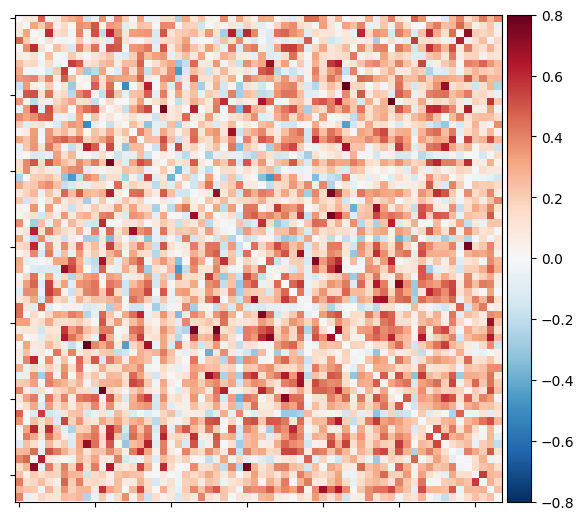

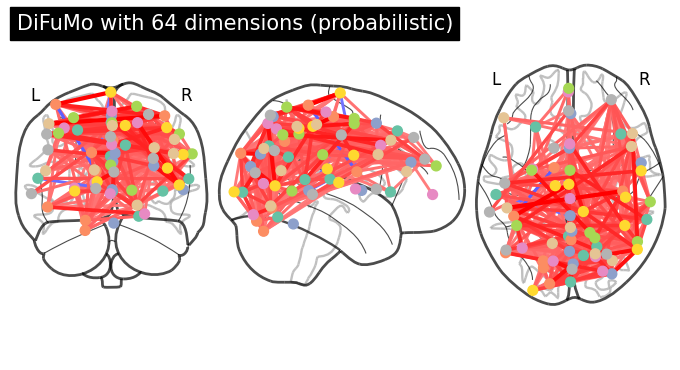

Check the folder for file name 'Connectome_Webview.html' and click on it.


In [15]:
PLotFCM(LoadedFCM)
PlotCoordinates(atlas, LoadedFCM, 64)
PlotWebView(atlas, LoadedFCM)